--2025-09-14 13:43:34--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 142.250.145.207, 74.125.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  30.0MB/s    in 2.2s    

2025-09-14 13:43:37 (30.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8840 - loss: 0.2579 - val_accuracy: 0.9670 - val_loss: 0.0939
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9620 - loss: 0.0978 - val_accuracy: 0.9620 - val_loss: 0.0955
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9602 - loss: 0.0905 - val_accuracy: 0.9620 - val_loss: 0.0935
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9701 - loss: 0.0875 - val_accuracy: 0.9650 - val_loss: 0.1036
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9695 - loss: 0.0792 - val_accuracy: 0.9580 - val_loss: 0.1081


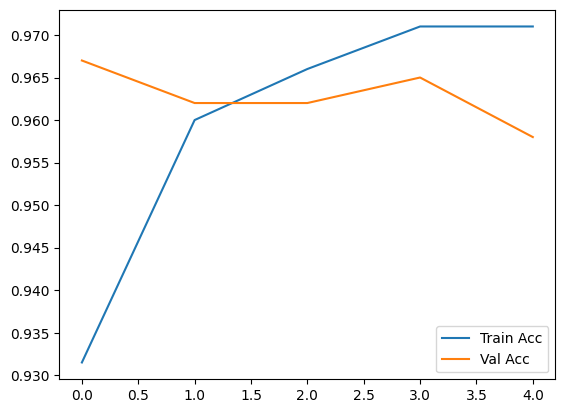

✅ Model Saved Successfully!


In [2]:
# Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os, zipfile

# Step 2: Download Dataset (Kaggle Dogs vs Cats)
# If running in Colab
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
with zipfile.ZipFile("cats_and_dogs_filtered.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

train_dir = "data/cats_and_dogs_filtered/train"
val_dir = "data/cats_and_dogs_filtered/validation"

# Step 3: Data Preprocessing
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

# Step 4: Load Pre-trained MobileNetV2
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze base model layers

# Step 5: Add Custom Layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Step 6: Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train Model
history = model.fit(train_gen, validation_data=val_gen, epochs=5)

# Step 8: Plot Accuracy & Loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

# Step 9: Save Model
model.save("dogs_vs_cats_mobilenet.h5")
print("✅ Model Saved Successfully!")

# Step 10: Prediction on Single Image
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_img(path, model):
    img = image.load_img(path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    pred = model.predict(img_array)[0][0]
    print("Prediction:", "🐶 Dog" if pred > 0.5 else "🐱 Cat")

# Example:
# predict_img("data/cats_and_dogs_filtered/validation/cats/cat.2000.jpg", model)



In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = (preds > 0.5).astype("int32")
y_true = val_gen.classes

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))


32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 814ms/step
[[238 262]
 [242 258]]
              precision    recall  f1-score   support

         Cat       0.50      0.48      0.49       500
         Dog       0.50      0.52      0.51       500

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000



In [5]:
# Create validation generator again without shuffle
val_gen_no_shuffle = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False   # 🚨 Important fix
)

# Predict again
preds = model.predict(val_gen_no_shuffle, verbose=1)
y_pred = (preds > 0.5).astype("int32")
y_true = val_gen_no_shuffle.classes

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=list(val_gen_no_shuffle.class_indices.keys())))


Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 735ms/step
[[469  31]
 [ 11 489]]
              precision    recall  f1-score   support

        cats       0.98      0.94      0.96       500
        dogs       0.94      0.98      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

